In [9]:
import pandas as pd
import datetime as dt
import numpy as np

import math
import matplotlib.pyplot as plt
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
from scipy.optimize import minimize
%matplotlib inline

from statsmodels.tools.sm_exceptions import ConvergenceWarning

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore', category=ConvergenceWarning)


#https://habrahabr.ru/post/207160/
#https://habrahabr.ru/post/210530/
#https://habrahabr.ru/post/207160/
#https://habrahabr.ru/company/ods/blog/327242/

## Читаем данные

In [10]:
df=pd.read_pickle('MG_Sales.pickle',compression='gzip')

## Формируем выборку временного ряда

In [11]:
time_series=pd.DataFrame(data=df[(df['ЦветМеталла']=='Красное золото')&(df['Дата']>=dt.date(2015,1,1))].groupby('Дата')['Количество'].sum())
time_series.index.name='ds'
time_series.columns=['y']
#time_series=time_series.applymap(np.log)

## Отрисовка графика

In [ ]:
def tsplot(y, lags=None, figsize=(20,12), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))

        y.plot(ax=ts_ax)
        ts_ax.set_title('График временного ряда (Среднее по дням)')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)

        test=sm.tsa.stattools.adfuller(y)
        print ('p-value: ', test[1])
        if test[0]> test[4]['5%']: 
            print ('есть единичные корни, ряд не стационарен')
        else:
            print ('единичных корней нет, ряд стационарен')

        plt.tight_layout()
    return 

tsplot(time_series.y, lags=7)

## Анализ стационарности ряда

In [ ]:
m = time_series.index[int(len(time_series.index)/2+1)]
r1 = sm.stats.DescrStatsW(time_series[m:])
r2 = sm.stats.DescrStatsW(time_series[:m])
p_value=sm.stats.CompareMeans(r1,r2).ttest_ind()[1]
print ('p-value: ', p_value)
if p_value[0]>0.05:
    print('Ряд близок к стационарному') 
else: 
    print('Ряд не стационарен')

In [ ]:
p_value[0]

In [ ]:
_otg = time_series
_otg.plot(figsize=(20,12))

## Преобразование Бокса-Кокса

In [12]:
# преобразование 
def invboxcox(y,lmbda):
    # обрабтное преобразование Бокса-Кокса
    if lmbda == 0:
        return(np.exp(y))
    else:
        return(np.exp(np.log(lmbda*y+1)/lmbda))

_otg=time_series.copy()
_otg.y, lmbda = scs.boxcox(_otg.y+1) # прибавляем единицу, так как в исходном ряде есть нули
print('Параметр lmbda Бокса-Кокса',lmbda)

date_div=dt.datetime(2017,4,1)
time_series_train=_otg.loc[:date_div-dt.timedelta(seconds=1)]
time_series_test=_otg.loc[date_div:]

#_otg = time_series.applymap(np.log)
#_otg.plot(figsize=(20,12))
#lag=365
#print ('lag=',str(lag),', p-value: ',sm.tsa.adfuller(_otg.y, maxlag=lag)[1])

Параметр lmbda Бокса-Кокса -0.284728487847


## Поиск лага

In [ ]:
def getBestLag(data):    
    lag=-1
    for lag in range(31):
        if lag==0: continue
            
        try:
            diff1lev = data.diff(periods=lag).dropna()    
            test=sm.tsa.stattools.adfuller(diff1lev.y)
        except:
            continue
            
        if test[0]> test[4]['5%']: continue        
        if math.isnan(test[1]): continue
        
        return lag,test[1]

auto_lag,p_value=getBestLag(_otg)
print('auto_lag=',auto_lag,' p_value=',p_value)

In [ ]:
#Визуализируем диффиренцирование
diff1lev_season = _otg.diff(auto_lag).dropna()
diff1lev_season.plot(figsize=(20,12))

print ('p-value: ',sm.tsa.adfuller(diff1lev_season.y)[1])

In [ ]:
#Оценка нормальности распределения
jb_test = sm.stats.stattools.jarque_bera(_otg)
a = np.vstack([jb_test])

jb_test[1][0]>0.05

In [ ]:
diff1lev_season1lev = diff1lev_season.diff().dropna()
print ('p.value: ' , sm.tsa.adfuller(diff1lev_season1lev.y, maxlag=52)[1])

## Модель ARIMA

нам нужно знать ее порядок, состоящий из 2-х параметров:

p — порядок компоненты AR

d — порядок интегрированного ряда

q — порядок компонетны MA

Параметр d есть и он равет 1, осталось определить p и q. Для их определения нам надо изучить авторкорреляционную(ACF) и частично автокорреляционную(PACF) функции для ряда первых разностей.
ACF поможет нам определить q, т. к. по ее коррелограмме можно определить количество автокорреляционных коэффициентов сильно отличных от 0 в модели MA
PACF поможет нам определить p, т. к. по ее коррелограмме можно определить максимальный номер коэффициента сильно отличный от 0 в модели AR.

## Определяем порядок сезонных составляющих P,D,Q.
P — порядок сезонной составляющей SAR(P)

D — порядок интегрирования сезонной составляющей

Q — порядок сезонной составляющей SMA(Q)

Начнем с определения параметра D. Он определет порядок интегрированности сезонной разности, т.е. в нашем случае он равен 1. Для определения P и Q нам как и прежде надо построить коррелограммы ACF и PACF.

In [ ]:
fig = plt.figure(figsize=(20,12))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(diff1lev_season1lev.values.squeeze(), lags=150, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(diff1lev_season1lev, lags=150, ax=ax2)

 Частичная автокорреляция — это автокорреляция после снятия авторегрессии предыдущего порядка
 p = 0, т.к. на ней только 0 лаг сильно отличнен от нуля в PACF
    
Параметр q задаётся номером последнего несезонного лага, при котором автокорреляция значима (последнее значение слева которое не попадает в доверительный интервал в графике автокорреляции). 
 q = 1

## Подбор параметров модели SARIMAX

In [13]:
import statsmodels.tsa.api as smt
from tqdm import tqdm

In [ ]:
warnings.simplefilter('ignore', category=ConvergenceWarning)
warnings.simplefilter('ignore', category=RuntimeWarning)

Ps=[1,2]
ps=[1,2]
Ds=[1]
ds=[1]
Qs=[6,7,8,9]
qs=[5,6,7,8,9]
tr=['t','c','ct','n']
lag=7#сезонность дней, потому что датасет в днях


best_aic = float("inf")
best_params=[]

pbar = tqdm(total=len(Ps)*len(ps)*len(Ds)*len(ds)*len(Qs)*len(qs)*len(tr))
for trend in tr:#наличие константы в моделе
    for P in Ps:#авторегрессия модели по сезону    
        for D in Ds:#дифференцирование по сезону            
            for d in ds:#дифференцирование внутри сезона                        
                for p in ps:#авторегрессия модели внутри сезона            
                    for Q in Qs:#скользящее среднее по сезону
                        for q in qs:#скользящее среднее внутри сезона
                            pbar.update(1)
            
                            #try except нужен, потому что на некоторых наборах параметров модель не обучается
                            try:
                                model=sm.tsa.statespace.SARIMAX(time_series_train, order=(p, d, q),#(p,d,q) 
                                        seasonal_order=(P, D, Q, 7),#(P,D,Q,s)
                                        trend=trend                                        
                                       ).fit(disp=False)    
                            except:
                                #print('wrong parameters:', param)
                                continue
                            
                            aic = model.aic
                                                                                    
                            #сохраняем лучшую модель, aic, параметры
                            if math.isnan(aic): 
                                pbar.update(len(qs)-Qs.index(q)-1)
                                break
                            if aic >= best_aic: continue
                            #if aic<0: continue
                                
                            best_model = model
                            best_aic = aic
                            print('-----> ','D=',D,' d=',d,' Q=',Q,' q=',q,' P=',P,' p=',p,'trend=',trend,' best_aic: ',aic)                            
                                                        
    
warnings.filterwarnings('default')
pbar.close()

  0%|                                                  | 0/320 [00:00<?, ?it/s]

----->  D= 1  d= 1  Q= 6  q= 5  P= 1  p= 1 trend= t  best_aic:  -1874.39708603


  1%|▎                                         | 2/320 [00:12<32:56,  6.21s/it]

----->  D= 1  d= 1  Q= 6  q= 6  P= 1  p= 1 trend= t  best_aic:  -1875.74082707


  7%|██▊                                      | 22/320 [00:38<31:07,  6.27s/it]

----->  D= 1  d= 1  Q= 6  q= 6  P= 1  p= 2 trend= t  best_aic:  -1875.84060334


 13%|█████▍                                   | 42/320 [01:08<31:47,  6.86s/it]

----->  D= 1  d= 1  Q= 6  q= 6  P= 2  p= 1 trend= t  best_aic:  -1875.87100026


 19%|███████▉                                 | 62/320 [02:38<45:49, 10.66s/it]

----->  D= 1  d= 1  Q= 6  q= 6  P= 2  p= 2 trend= t  best_aic:  -1875.92689297


 23%|████████▉                              | 73/320 [04:01<1:10:37, 17.16s/it]

----->  D= 1  d= 1  Q= 6  q= 5  P= 1  p= 1 trend= c  best_aic:  -2072.00657198


 48%|██████████████████▏                   | 153/320 [13:24<1:59:39, 42.99s/it]

In [7]:
#D: 0  d: 1  Q: 6  q: 4  P: 1  p: 0 trend: c  best_aic:  -2872.71653779
#D= 1  d= 1  Q= 6  q= 4  P= 1  p= 3 trend= t  best_aic:  -1879.84045493
#D= 1  d= 1  Q= 6  q= 5  P= 1  p= 1 trend= c  best_aic:  -2072.00657198
#p, d, q, P, D, Q=result
#trend= 't'
D=1
d=1
Q=6
q=4
P=1
p=3
trend='t'


best_model=sm.tsa.statespace.SARIMAX(time_series_train, 
                                order=(int(p), int(d), int(q)),#(p,d,q)                                     
                                seasonal_order=(int(P), int(D), int(Q), 7),#(P,D,Q,s) 
                                trend=trend,
                                enforce_stationarity=False,
                                enforce_invertibility=False
                                ).fit(disp=False) 
#print(model.summary()) 

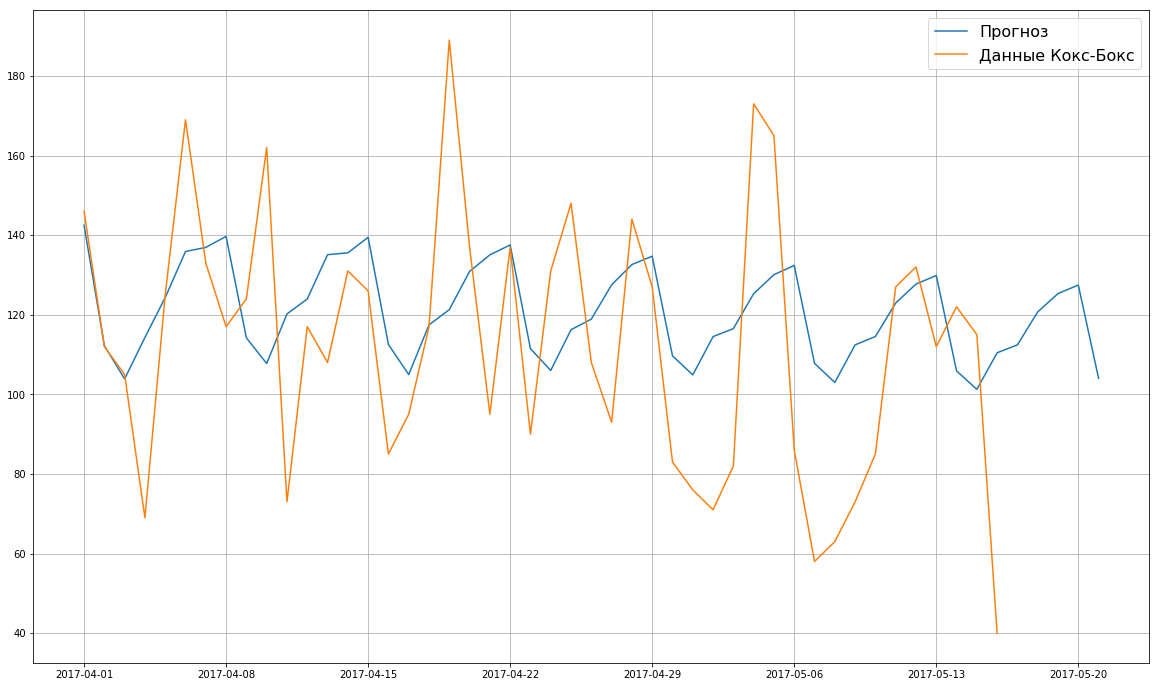

In [8]:
forecast=invboxcox(best_model.predict(start = time_series_train.shape[0], end = time_series_train.shape[0]+50), lmbda)

plt.figure(figsize=(20,12))
plt.plot(forecast, label = "Прогноз")
plt.plot(invboxcox(_otg.loc[dt.datetime(2017,4,1):],lmbda), label = "Данные Кокс-Бокс")
#plt.axvspan(len(data)-128, time_series_test.shape()[0], alpha=0.5, color='lightgrey')
plt.grid(True)
plt.axis('tight')
plt.legend(loc="best", fontsize=16);